## Data Preprocessing

In [1]:
# import core libraries 
import datetime
import json
import re
import csv
import ast
import pprint
import pathlib
import itertools
from collections import Counter
from itertools import islice

# import third-party libraries
import numpy as np
import pandas as pd

# import visualizations
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set directory path data
syria_data_dir = pathlib.Path('/Users/adamstueckrath/Desktop/syria_data/')

# tweets_no_rts_csv file path
tweets_no_rts_csv = syria_data_dir / 'tweets_no_retweets' / 'tweets_no_retweets.csv'


## Tweet Data Processing

In [3]:
def string_to_datetime(tweet_date):
    """
    Turns a datetime string like this: 
    '2017-07-06T18:34:37.000Z' 
    to a Python datetime object like this -> 2017-07-06 18:34:41
    """
    return datetime.datetime.strptime(tweet_date, "%Y-%m-%dT%H:%M:%S.%fZ")


In [4]:
# load tweets into dataframe from csv file
tweets_no_rts_df = pd.read_csv(tweets_no_rts_csv, header=0,
                               parse_dates=['tweet_created_at'],
                               usecols=['tweet_id', 'tweet_id_str',
                                        'tweet_lang','tweet_created_at',
                                        'user_name','user_id_str','tweet_text'],
                               date_parser=string_to_datetime)


### Filter tweets for english only

In [5]:
tweets_no_rts_df.shape

(1160088, 7)

In [6]:
tweets_no_rts_df = tweets_no_rts_df[tweets_no_rts_df['tweet_lang'] =='en']
tweets_no_rts_df = tweets_no_rts_df.reset_index(drop=True)


In [7]:
tweets_no_rts_df.shape

(638161, 7)

### Clean tweet text

Pre-processing
Pre-processing the data is the process of cleaning and preparing the text for classification. Online texts contain usually
lots of noise and uninformative parts such as HTML tags, scripts and advertisements. In addition, on words level, many
words in the text do not have an impact on the general orientation of it.

Keeping those words makes the dimensionality of the problem high and hence the classification more difficult since each
word in the text is treated as one dimension. Here is the hypothesis of having the data properly pre-processed: to reduce the
noise in the text should help improve the performance of the classifier and speed up the classification process, thus aiding in
real time sentiment analysis.

In [8]:
def clean_text(text):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    use this for removing digits -> return re.sub('\d+', '', input_text)
    '''
    text = text.lower()
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())


In [9]:
tweets_no_rts_df['tweet_text_clean'] = tweets_no_rts_df['tweet_text'].apply(clean_text)


## Sentiment Analysis 

https://github.com/cjhutto/vaderSentiment

NLTK’s built-in Vader Sentiment Analyzer will simply rank a piece of text as positive, negative or neutral using a lexicon of positive and negative words.

We can utilize this tool by first creating a Sentiment Intensity Analyzer (SIA) to categorize the tweets, then we'll use the compound value to get the sentiment.

What makes VADER great for social media text?
As you might have guessed, the fact that lexicons are expensive and time-consuming to produce means they are not updated all that often. This means they lack a lot of current slang that may be used to express how a person is feeling.


Terminology:

* **Corpora**: is the plural for corpus.
* **Corpus**: basically means a body, and in the context of Natural Language Processing (NLP), it means a body of text.
* **Lexicon**: A lexicon, or lexical resource, is a collection of words and/or phrases along with associated information, such as part-of-speech and sense definitions. Lexical resources are secondary to texts, and are usually created and enriched with the help of texts.In NLTK, any lexicon is considered a corpus since a list of words is also a body of text.
* **WordNet**: is lexical database for the English language (it's like a lexicon/dictionary with word-to-word relations. 

The NLTK Lemmatization method is based on WordNet’s built-in morphy function. Here is the introduction from WordNet official website:

WordNet® is a large lexical database of English. Nouns, verbs, adjectives and adverbs are grouped into sets of cognitive synonyms (synsets), each expressing a distinct concept. Synsets are interlinked by means of conceptual-semantic and lexical relations. The resulting network of meaningfully related words and concepts can be navigated with the browser. WordNet is also freely and publicly available for download. WordNet’s structure makes it a useful tool for computational linguistics and natural language processing.

WordNet superficially resembles a thesaurus, in that it groups words together based on their meanings. However, there are some important distinctions. First, WordNet interlinks not just word forms—strings of letters—but specific senses of words. As a result, words that are found in close proximity to one another in the network are semantically disambiguated. Second, WordNet labels the semantic relations among words, whereas the groupings of words in a thesaurus does not follow any explicit pattern other than meaning similarity

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    '''
    Utility function to classify the polarity of a tweet
    using nltk. analysis variable returns the following dict: 
    {'neg': 0.122, 'neu': 0.641, 'pos': 0.237, 'compound': 0.4215}
    The compound value here conveys the overall positive or negative user experience.
    Examples: 
    https://www.programcreek.com/python/example/100005/nltk.sentiment.vader.SentimentIntensityAnalyzer
    https://opensourceforu.com/2016/12/analysing-sentiments-nltk/
    '''
    analysis = analyzer.polarity_scores(text)
    return analysis['compound']


/Users/adamstueckrath/.pyenv/versions/3.6.5/envs/syria-project-3.6.5/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [11]:
tweets_no_rts_df['tweet_sentiment_compound'] = tweets_no_rts_df['tweet_text_clean'].apply(analyze_sentiment)


**About the Scoring**
The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

* positive sentiment: compound score >= 0.05
* neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
* negative sentiment: compound score <= -0.05

Our dataframe consists of four columns from the sentiment scoring: Neu, Neg, Pos and compound. The first three represent the sentiment score percentage of each category in our headline, and the compound single number that scores the sentiment. `compound` ranges from -1 (Extremely Negative) to 1 (Extremely Positive).

We will consider posts with a compound value greater than 0.2 as positive and less than -0.2 as negative. There's some testing and experimentation that goes with choosing these ranges, and there is a trade-off to be made here. If you choose a higher value, you might get more compact results (less false positives and false negatives), but the size of the results will decrease significantly.

I had originally gone with the NLTK documentation of suggestion of 0.5 and -0.5 as positive/negative. However my results too compact: 


In [12]:
def sentiment_score_suggested(compound):
    if compound > 0.5:
        return 1
    elif compound < -0.5:
        return -1
    else:
        return 0
    

In [13]:
tweets_no_rts_df['tweet_sentiment_score'] = tweets_no_rts_df['tweet_sentiment_compound'].apply(sentiment_score_suggested)
tweets_no_rts_df['tweet_sentiment_score'].value_counts()


 0    434390
-1    135277
 1     68494
Name: tweet_sentiment_score, dtype: int64

In [14]:
def sentiment_score(compound):
    if compound > 0.2:
        return 1
    elif compound < -0.2:
        return -1
    else:
        return 0
    

In [15]:
tweets_no_rts_df['tweet_sentiment_score'] = tweets_no_rts_df['tweet_sentiment_compound'].apply(sentiment_score)
tweets_no_rts_df['tweet_sentiment_score'].value_counts()


 0    244735
-1    238936
 1    154490
Name: tweet_sentiment_score, dtype: int64

In [16]:
def sentiment_label(score):
    if score == 1:
        return 'positive'
    elif score == -1:
        return 'negative'
    else:
        return 'neutral'
    

In [17]:
tweets_no_rts_df['tweet_sentiment_label'] = tweets_no_rts_df['tweet_sentiment_score'].apply(sentiment_label)


In [18]:
tweets_no_rts_df['tweet_sentiment_label'].value_counts()


neutral     244735
negative    238936
positive    154490
Name: tweet_sentiment_label, dtype: int64

## Sentiment Charts

In [19]:
print("Positive headlines:\n")
pprint.pprint(list(tweets_no_rts_df[tweets_no_rts_df['tweet_sentiment_label'] == 'positive'].tweet_text)[20:25], width=300)

print("\n")

print("\nNegative headlines:\n")
pprint.pprint(list(tweets_no_rts_df[tweets_no_rts_df['tweet_sentiment_label'] == 'negative'].tweet_text)[20:25], width=300)


Positive headlines:

['@sahouraxo i hear syria used to be a beautiful country too',
 'POLITICO - Posts | Trump declined to say clearly that he believes... https://t.co/MvqabWLKfM https://t.co/v8FCfOXC5v',
 "@justgivemesun I tell producers daily! It's called Freedom of speech! Rep.Gabhard is a liberal living in Hawaii cla… https://t.co/m2yQSNkoSJ",
 '@TIME Does that include children in Syria?  Because saying so and doing something to help are different.',
 '@kwilli1046 They need to be sent to that beautiful country called Syria!!!!\n😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😜😄😜😜😜😜😜😜😜']



Negative headlines:

['I liked a @YouTube video https://t.co/zo5YUOyXyM Tillerson calls for Syria unity, no-fly zone as Russia alerts over chemical attacks',
 'Team probing Syria chemical attacks comes under pressure https://t.co/8BvdEhGNNG',
 "@Deplorable80210 She lives in Hawaii and is totally clueless! US doesn't support Syria Terrorist! Unless Obama did… https://t.co/PtxJIQCvHR",
 'Global inquiry aims

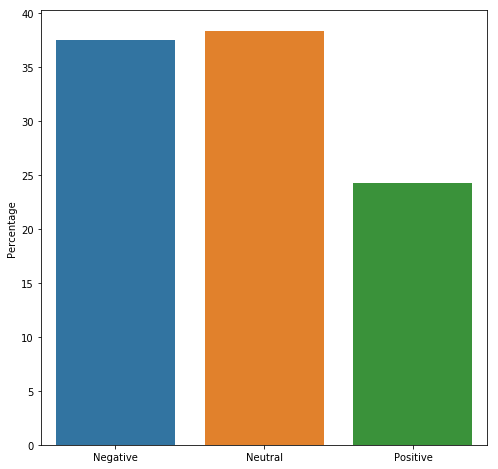

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
counts = tweets_no_rts_df.tweet_sentiment_score.value_counts(normalize=True) * 100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
plt.show()


The large number of neutral tweets is due to two main reasons:
1. The assumption that we made earlier where text with compound value between 0.2 and -0.2 are considered neutral. The higher the margin, the larger the number of neutral tweets.
2. We used general lexicon to categorize tweets. The more correct way is to use a conflict-specific lexicon, but for that we would either need a human to manually label data, or we would need to find a custom lexicon already made.

## Tokenization

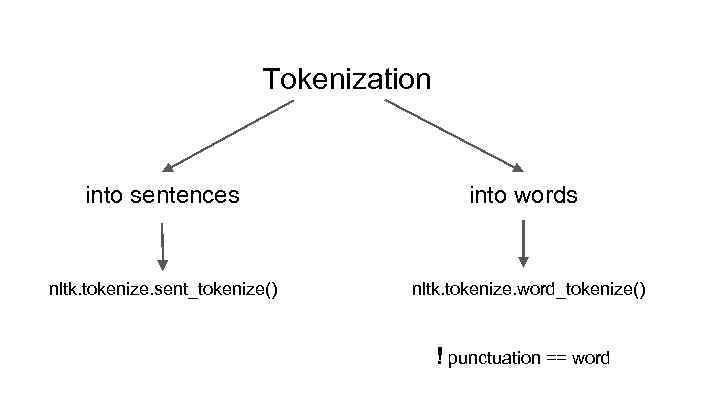

It is a process of breaking up the given text into small units such as sentences or words. It does this work / task by locating word boundaries. What is word boundaries? Ending point of a word & beginning of the next word is called word boundary. Tokenization is also known as word segmentation.


In [21]:
from nltk.tokenize import word_tokenize

def tokenize_text(text):
    return word_tokenize(text)


In [22]:
tweets_no_rts_df['tweet_text_tokenize'] = tweets_no_rts_df['tweet_text_clean'].apply(tokenize_text)


## Stemming and removing stop words

**Stop Words**

Stopwords considered as noise in the text. Text may contain stop words such as is, am, are, this, a, an, the, etc.

In NLTK for removing stopwords, you need to create a list of stopwords and filter out your list of tokens from these words.


**Lemmatization**

The process of removing prefixes, suffixes from the words and reduce them to their stem form. It refers to map a word form to basic word. Words forms may differ from stem due to morphological changes and grammatical reasons. For example, the word “computation”, might be stemmed to “comput”.

So to redefine in simple words it is a process of chopping off the end of the word to leave only the base. It is a part of linguistic studies in Morphology and Artificial Intelligence for information extraction and retrieval.

Stemming and AI knowledge extract meaningful information from vast sources like big data and Internet. Finally when the stem of a word is recognized the further it makes easier to return search results.

Lemmatization is very similar to stemming, but is more akin to synonym replacement. A lemma is a root word, as opposed to the root stem. So unlike stemming, you are always left with a valid word which means the same thing. But the word you end up with can be completely different. A few examples will explain lemmatization...

In [23]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(text):
    filtered_text = list(filter(lambda l: l not in stop_words, text))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_text]
    return lemmas


In [24]:
tweets_no_rts_df['tweet_text_normalize'] = tweets_no_rts_df['tweet_text_tokenize'].apply(normalizer)


In [25]:
tweets_no_rts_df.head()

,tweet_id,tweet_id_str,tweet_created_at,tweet_lang,tweet_text,user_id_str,user_name,tweet_text_clean,tweet_sentiment_compound,tweet_sentiment_score,tweet_sentiment_label,tweet_text_tokenize,tweet_text_normalize
0,595e82d713bbf01307babbbd,883031462043414528,2017-07-06 18:34:41,en,@Autumblues @JudeStevens @CBCNews So Syria and...,136332449,Gab.ai ➡,so syria and libya is on who but lets hear the...,0.0000,0,neutral,"[so, syria, and, libya, is, on, who, but, lets...","[syria, libya, let, hear, excuse, 4, 3, 2, 1, go]"
1,595e82d713bbf01307babbc6,883031512031125505,2017-07-06 18:34:53,en,@Diane1hDiane SHE'S FAR FROM CLUELESS. UNLIKE ...,796834612416811009,WakeUP2017,she s far from clueless unlike most including ...,-0.4215,-1,negative,"[she, s, far, from, clueless, unlike, most, in...","[far, clueless, unlike, including, congress, a..."
2,595e82d713bbf01307babbc9,883031518972608512,2017-07-06 18:34:54,en,See footage from the #G20 #WelcomeToHell prote...,2429008230,Vero Ger,see footage from the g20 welcometohell protest...,-0.2263,-1,negative,"[see, footage, from, the, g20, welcometohell, ...","[see, footage, g20, welcometohell, protest, ha..."
3,595e82d713bbf01307babbcb,883031525905793026,2017-07-06 18:34:56,en,Global inquiry aims to report on Syria sarin a...,817450572026703874,NEWS,global inquiry aims to report on syria sarin a...,-0.4767,-1,negative,"[global, inquiry, aims, to, report, on, syria,...","[global, inquiry, aim, report, syria, sarin, a..."
4,595e82d713bbf01307babbcd,883031529303232512,2017-07-06 18:34:57,en,@TheSwogBlog Bill liked Trump's muh holocaust ...,882690403886956544,Andrew Saxon,bill liked trump s muh holocaust amp russia sy...,0.1531,0,neutral,"[bill, liked, trump, s, muh, holocaust, amp, r...","[bill, liked, trump, muh, holocaust, amp, russ..."


In [26]:
tweets_no_rts_df.iloc[7]['tweet_text']

'@ShaunKing Maybe you should tell everyone that wants to come here that. Where would you like to start? Syria? Why d… https://t.co/x8IY58aTIg'

In [27]:
tweets_no_rts_df.iloc[7]['tweet_text_normalize']

['maybe',
 'tell',
 'everyone',
 'want',
 'come',
 'would',
 'like',
 'start',
 'syria']

## Save data for training and testing 

In [28]:
# tweets_no_rts_csv file path
tweets_pre_processed_csv = syria_data_dir / 'model' / 'model_data' /'tweets_pre_processed.csv'

# write tweets to csv 
tweets_no_rts_df.to_csv(tweets_pre_processed_csv, index=False)